# __Papers:__
> Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> Biological pattern formation: fmm basic mechanisms ta complex structures

> [Link](https://doi.org/10.1103/RevModPhys.66.1481)

> In This notebook, estimate the parameters.

> We select the last 32 time steps of a 32 x 32 grid of a solution of ASDM. The Training dataset includes all grid's data point.

> The main PDE that the training dataset is created is as follow:

<h3><center>$\partial_t a = D_a (\partial_x^2 + \partial_y^2)a + \rho_a \frac{a^2 s}{1 + \kappa_a a^2} - \mu_a a + \sigma_a$</center></h3>

<h3><center>$\partial_t s = D_s (\partial_x^2 + \partial_y^2)s + \rho_s \frac{a^2 s}{1 + \kappa_a a^2} + \sigma_s$</center></h3>

With parameters  :
- $D_a = 0.005, \quad D_s=0.2$.
- $\mu_a = 0.01$.
- $\sigma_a = 0.0, \quad \sigma_s=0.02$.
- $\rho_a=0.01, \quad \rho_s = 0.02, \quad \kappa_a=0.25$

Using the following transformations
- <h3>$\tilde{a} = \frac{a}{\mu_a} , \qquad \tilde{s} = \frac{s}{\sigma_s}$.</h3>
- <h3>$\tilde{D_a} = \frac{D_a}{\mu_a} , \qquad \tilde{D_s} = \frac{D_s}{\sigma_s}$.</h3>
- <h3>$\tilde{\rho_a} = \frac{\rho_a}{\mu_a} , \qquad \tilde{\rho_s} = \frac{\rho_s}{\sigma_s}$.</h3>
- <h3>$\tilde{\sigma_a} = \frac{\sigma_a}{\mu_a}$.</h3>

**and the dimensionless equation obtains as**

<h3><center>$\partial_t \tilde{a} = \tilde{D}_a(\partial_x^2 + \partial_y^2)\tilde{a} + \tilde{\rho}_a\frac{\tilde{a}^2 \tilde{s}}{1 + \tilde{a}^2} - \tilde{a} + \tilde{\sigma}_a$</center></h3>

<h3><center>$\partial_t \tilde{s} =  \tilde{D}_s (\partial_x^2 + \partial_y^2)\tilde{s} - \tilde{\rho}_s \frac{\tilde{a}^2 \tilde{s}}{1 + \tilde{a}^2} + 1$</center></h3>

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time

In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, a, s, layers): 
        
        with tf.device('gpu:0'):
        #with tf.device('cpu:0'):
                 
            X = np.concatenate([x, y, t], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]

            self.a = a
            self.s = s

            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a_tilde = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_a_tilde", 
                                   constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.005, dtype=tf.float32, name="D_a")
            self.D_s_tilde = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_s_tilde",
                                  constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.2, dtype=tf.float32)#
            self.sigma_a_tilde = tf.Variable([0.0], dtype=tf.float32,
                                      name="sigma_a_tilde",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10)
                                      )#tf.constant(0.0, dtype=tf.float32, name="sigma_a")#
            self.sigma_s = tf.constant(0.02, dtype=tf.float32)#tf.Variable([1.00], dtype=tf.float32, 
                                       #name="sigma_s",
                                      #constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#
            self.mu_a = tf.constant(0.01, dtype=tf.float32)#tf.Variable([1.00], dtype=tf.float32, 
                                    #name="mu_a",
                                   #constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#
            self.rho_a_tilde = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_a_tilde",
                                    constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_s_tilde = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_s_tilde",
                                    constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.02, dtype=tf.float32, name="rho_s_tilde")#
            self.kappa_a = tf.Variable([1.00], dtype=tf.float32,
                                       name="kappa_a",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.25, dtype=tf.float32)#

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]], name="x_tf")
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]], name="t_tf")

        self.a_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_tf")
        self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_tf")                
                
                
        self.a_pred, self.s_pred, self.f_a_pred, self.f_s_pred, self.a_pred_tilde, self.s_pred_tilde = \
                             self.net_ASDM(self.x_tf, self.y_tf, self.t_tf)
        

        self.loss_1 = tf.reduce_sum(tf.square(self.a_tf - self.a_pred)) + \
                    tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) 

        self.loss_a = tf.reduce_sum(tf.square(self.f_a_pred), name = "loss_a")

        self.loss_s = tf.reduce_sum(tf.square(self.f_s_pred), name = "loss_s")
        

        self.loss = self.loss_1 + 10*self.loss_a + 10*self.loss_s 

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0        
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    
    def _a_transform(self, val_tensor):
        """a to a_tilde"""
        return val_tensor/self.mu_a
    
    def _s_transform(self, val_tensor):
        """s to s_tilde"""
        return val_tensor/self.sigma_s
    
    def _a_inv_transform(self, val_tensor):
        """a_tilde to a"""
        return val_tensor*self.mu_a
    
    def _s_inv_transform(self, val_tensor):
        """s_tilde to s"""
        return val_tensor*self.sigma_s
                    
    
    def net_as_transform(self, a, s):
        a_tilde = self._a_transform(a)
        s_tilde = self._s_transform(s)
        return (a_tilde, s_tilde)
    
    def net_as_inv_transform(self, a_tilde, s_tilde):
        a = self._a_inv_transform(a_tilde)      
        s = self._s_inv_transform(s_tilde)
        return (a, s)
        
    def net_ASDM(self, x, y, t):
        D_a_tilde = self.D_a_tilde
        D_s_tilde = self.D_s_tilde
        rho_a_tilde = self.rho_a_tilde
        rho_s_tilde = self.rho_s_tilde
        sigma_a_tilde = self.sigma_a_tilde
        kappa_a = self.kappa_a
        
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        #a = a_and_s[:,0:1]
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")
        #s = a_and_s[:,1:2]                
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")
         
        a_tilde, s_tilde = self.net_as_transform(a, s)
        
        a_t = tf.gradients(a_tilde, t)[0]
        a_t_temp = tf.identity(a_t, name="temp_a_t")
        
        a_x = tf.gradients(a_tilde, x)[0]
        a_y = tf.gradients(a_tilde, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        a_diff_temp = tf.identity(a_xx + a_yy, name="temp_a_diff")
        
        s_t = tf.gradients(s_tilde, t, name="s_t")[0]
        s_t_temp = tf.identity(s_t, name="temp_s_t")
        s_x = tf.gradients(s_tilde, x)[0]
        s_y = tf.gradients(s_tilde, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        s_diff_temp = tf.identity(s_xx + s_yy, name="temp_s_diff")
        
        f = a_tilde*a_tilde*s_tilde/(1 + kappa_a*a_tilde*a_tilde)
        kin_temp = tf.identity(f, name="temp_kin")
        f_a = a_t - D_a_tilde*(a_xx + a_yy) - rho_a_tilde*f + a_tilde - sigma_a_tilde
        f_s = s_t - D_s_tilde*(s_xx + s_yy) + rho_s_tilde*f - 1   
        
        
        
        return a, s, f_a, f_s , a_tilde, s_tilde
    
    def callback(self, loss, loss_a, loss_s, D_a, D_s, sigma_a,sigma_s,
                       rho_a, rho_s, mu_a, kappa_a):
        print(f"loss: {loss.tolist()}, loss_a: {loss_a.tolist()}, loss_s: {loss_s.tolist()},\n"
              f"D_a_tilde: {D_a.tolist()}, D_s_tilde: {D_s.tolist()}\n"
              f"sigma_a_tilde: {sigma_a.tolist()}, sigma_s: {sigma_s.tolist()}\n"
              f"rho_a_tilde: {rho_a.tolist()}, rho_s_tilde: {rho_s.tolist()}\n"
              f"mu_a: {mu_a.tolist()}, kappa_a: {kappa_a.tolist()}\n")
        
      
    def train(self, nIter, early_stop_thresh = None, print_iter = 100): 
        
        

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            loss_value = self.sess.run(self.loss, tf_dict)
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a_tilde)#[0]
                D_s_value = self.sess.run(self.D_s_tilde)#[0]
                sigma_a_value = self.sess.run(self.sigma_a_tilde)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a_tilde)#[0]
                rho_s_value = self.sess.run(self.rho_s_tilde)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"D_a_tilde: {D_a_value.tolist()}, D_s_tilde: {D_s_value.tolist()}\n"
                      f"sigma_a_tilde: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a_tilde: {rho_a_value.tolist()}, rho_s_tilde: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
            if early_stop_thresh is not None and early_stop_thresh >= loss_value:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)                
                D_a_value = self.sess.run(self.D_a_tilde)#[0]
                D_s_value = self.sess.run(self.D_s_tilde)#[0]
                sigma_a_value = self.sess.run(self.sigma_a_tilde)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a_tilde)#[0]
                rho_s_value = self.sess.run(self.rho_s_tilde)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"D_a_tilde: {D_a_value.tolist()}, D_s_tilde: {D_s_value.tolist()}\n"
                      f"sigma_a_tilde: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a_tilde: {rho_a_value.tolist()}, rho_s_tilde: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                break
                
            
      
    def train_batch(self, nIter, batch_size, early_stop_thresh = None, print_iter = 100):
        
        data_n = self.x.shape[0]
        batch_steps = data_n//batch_size
        batch_steps = batch_steps + (data_n-1)//(batch_steps*batch_size)
        
        data = np.concatenate([self.x, self.y, self.t, self.a, self.s], 1)
        indices = np.array(list(range(data_n)))
        
        arr_total_loss = np.zeros(nIter)
        arr_total_loss_a = np.zeros(nIter)
        arr_total_loss_s = np.zeros(nIter)
        
        arr_D_a = np.zeros(nIter)
        arr_D_s = np.zeros(nIter)
        arr_sigma_a = np.zeros(nIter)
        arr_sigma_s = np.zeros(nIter)
        arr_rho_a = np.zeros(nIter)
        arr_rho_s = np.zeros(nIter)
        arr_mu_a = np.zeros(nIter)
        arr_kappa_a = np.zeros(nIter)
        
        def _get_val(item):
            val = item.tolist()
            if type(val) is float:
                return val
            else:
                return val[0]
        

        
        
        start_time = time.time()
        for it in range(nIter):
            # Shuflle the batches in each epoch
            np.random.shuffle(indices)                        
            total_loss = 0
            total_loss_a = 0
            total_loss_s = 0
            
            for batch in range(batch_steps):
                start = batch*batch_size
                end = (batch+1)*batch_size
                end = end - (end//data_n)*(end%data_n)
                
                batch_indices = indices[start:end]
                
                tf_dict = {self.x_tf: data[batch_indices, 0:1], 
                           self.y_tf: data[batch_indices, 1:2], 
                           self.t_tf: data[batch_indices, 2:3],
                           self.a_tf: data[batch_indices, 3:4], 
                           self.s_tf: data[batch_indices, 4:5]}
                
                self.sess.run(self.train_op_Adam, tf_dict)
            
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                
                total_loss += loss_value
                total_loss_a += loss_a_value
                total_loss_s += loss_s_value
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time                
                D_a_value = self.sess.run(self.D_a_tilde)#[0]
                D_s_value = self.sess.run(self.D_s_tilde)#[0]
                sigma_a_value = self.sess.run(self.sigma_a_tilde)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a_tilde)#[0]
                rho_s_value = self.sess.run(self.rho_s_tilde)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]

                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss  : {total_loss.tolist()},\n"
                      f"D_a_tilde: {D_a_value.tolist()}, D_s_tilde: {D_s_value.tolist()}\n"
                      f"sigma_a_tilde: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a_tilde: {rho_a_value.tolist()}, rho_s_tilde: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()

            if early_stop_thresh is not None and early_stop_thresh >= total_loss:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time                    
                D_a_value = self.sess.run(self.D_a_tilde)#[0]
                D_s_value = self.sess.run(self.D_s_tilde)#[0]
                sigma_a_value = self.sess.run(self.sigma_a_tilde)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a_tilde)#[0]
                rho_s_value = self.sess.run(self.rho_s_tilde)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss  : {total_loss.tolist()},\n"
                      f"D_a_tilde: {D_a_value.tolist()}, D_s_tilde: {D_s_value.tolist()}\n"
                      f"sigma_a_tilde: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a_tilde: {rho_a_value.tolist()}, rho_s_tilde: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
                arr_total_loss[it] = total_loss
                arr_total_loss_a[it] = total_loss_a
                arr_total_loss_s[it] = total_loss_s
                arr_total_loss[it] = total_loss
                arr_total_loss_a[it] = total_loss_a
                arr_total_loss_s[it] = total_loss_s
                arr_D_a[it] = _get_val(D_a_value)
                arr_D_s[it] = _get_val(D_s_value)
                arr_sigma_a[it] = _get_val(sigma_a_value)
                arr_sigma_s[it] = _get_val(sigma_s_value)
                arr_rho_a[it] = _get_val(rho_a_value)
                arr_rho_s[it] = _get_val(rho_s_value)
                arr_mu_a[it] = _get_val(mu_a_value)
                arr_kappa_a[it] = _get_val(kappa_a_value)
                                
                params = {'D_a': arr_D_a[:(it+1)], 'D_s': arr_D_s[:(it+1)], 
                          'sigma_a': arr_sigma_a[:(it+1)] , 'sigma_s': arr_sigma_s[:(it+1)],
                          'rho_a' : arr_rho_a[:(it+1)], 'rho_s' : arr_rho_s[:(it+1)],
                          'mu_a': arr_mu_a[:(it+1)], 'kappa_a': arr_kappa_a[:(it+1)]}
                
                return (arr_total_loss[:(it+1)], arr_total_loss_a[:(it+1)], arr_total_loss_s[:(it+1)], params)    
        
            arr_total_loss[it] = total_loss
            arr_total_loss_a[it] = total_loss_a
            arr_total_loss_s[it] = total_loss_s
            arr_D_a[it] = _get_val(D_a_value)
            arr_D_s[it] = _get_val(D_s_value)
            arr_sigma_a[it] = _get_val(sigma_a_value)
            arr_sigma_s[it] = _get_val(sigma_s_value)
            arr_rho_a[it] = _get_val(rho_a_value)
            arr_rho_s[it] = _get_val(rho_s_value)
            arr_mu_a[it] = _get_val(mu_a_value)
            arr_kappa_a[it] = _get_val(kappa_a_value)
            
        # end for it
        params = {'D_a': arr_D_a, 'D_s': arr_D_s, 'sigma_a': arr_sigma_a , 'sigma_s': arr_sigma_s,
                  'rho_a' : arr_rho_a, 'rho_s' : arr_rho_s, 'mu_a': arr_mu_a, 'kappa_a': arr_kappa_a}
        return (arr_total_loss, arr_total_loss_a, arr_total_loss_s, params)
        
    def minimise(self, max_iter = None, f_tol = None):
        if max_iter is not None:
            self.optimizer.optimizer_kwargs['options']['maxiter'] = max_iter
            
        if f_tol is not None:
            self.optimizer.optimizer_kwargs['options']['f_tol'] = f_tol
        
        
        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_a, self.loss_s,
                                           self.D_a_tilde, self.D_s_tilde,
                                          self.sigma_a_tilde, self.sigma_s,
                                          self.rho_a_tilde, self.rho_s_tilde,
                                          self.mu_a, self.kappa_a],
                                loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [3]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = 32#10#t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x = L*np.linspace(0,1,x_size)
y = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x, y, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
#idx = np.random.choice(N*T, T*32, replace=False)
idx = list(range(N*T))
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
a_train = a[idx,:]
s_train = s[idx,:]




In [ ]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, layers)
loss, loss_a, loss_s, params_estimates = \
model.train_batch(10000, batch_size=N*T//512, early_stop_thresh=10.0, print_iter=100)

It: 0, loss_a  : 30757.71814585, loss_s  : 14699.57638559, loss  : 546649.6053619385,
D_a_tilde: [0.983012855052948], D_s_tilde: [0.9789803624153137]
sigma_a_tilde: [0.041842032223939896], sigma_s: 0.019999999552965164
rho_a_tilde: [1.0025177001953125], rho_s_tilde: [0.9774304628372192]
mu_a: 0.009999999776482582, kappa_a: [1.0113407373428345], 
Time:8.44

It: 100, loss_a  : 80.05517752, loss_s  : 0.13184411, loss  : 13141.468297958374,
D_a_tilde: [0.676196813583374], D_s_tilde: [2.182409298256971e-05]
sigma_a_tilde: [0.2932334840297699], sigma_s: 0.019999999552965164
rho_a_tilde: [1.120628833770752], rho_s_tilde: [0.014881343580782413]
mu_a: 0.009999999776482582, kappa_a: [1.0347466468811035], 
Time:537.08

It: 200, loss_a  : 64.89450271, loss_s  : 0.16573004, loss  : 10847.28228855133,
D_a_tilde: [0.4662562310695648], D_s_tilde: [0.00021084348554722965]
sigma_a_tilde: [0.43407297134399414], sigma_s: 0.019999999552965164
rho_a_tilde: [1.2545759677886963], rho_s_tilde: [0.0138740399852

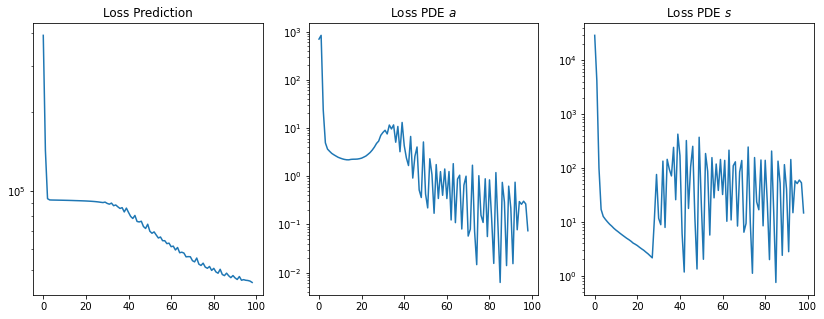

In [7]:
start = 0
end = -1
_ = plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.plot(loss[start:end])
plt.yscale('log')
plt.title("Loss Prediction")

plt.subplot(1,3,2)
plt.plot(loss_a[start:end])
plt.yscale('log')
plt.title(r"Loss PDE $a$")


plt.subplot(1,3,3)
plt.plot(loss_s[start:end])
plt.yscale('log')
plt.title(r"Loss PDE $s$")

plt.show()

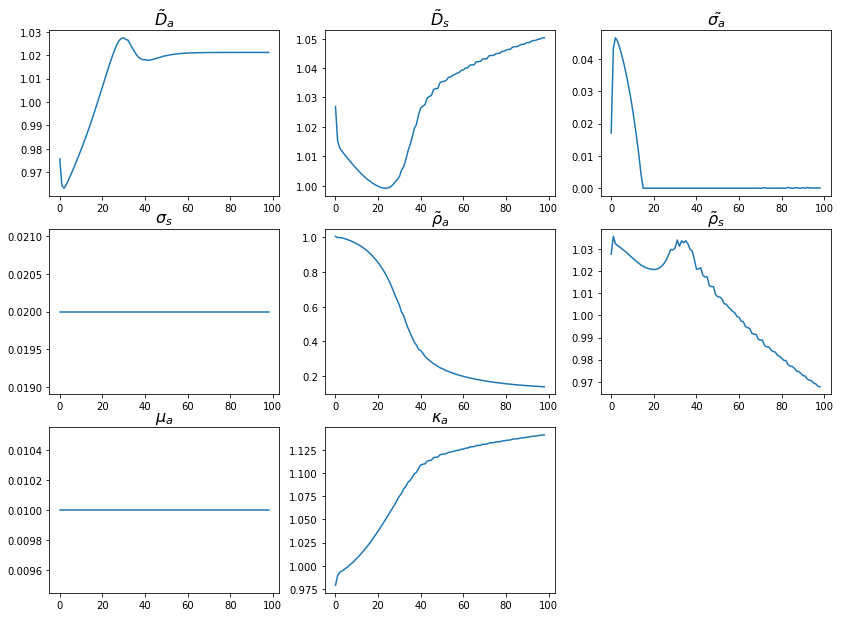

In [11]:
start = 0
end = -1
_ = plt.figure(figsize=(14,14))
plt.subplot(4,3,1)
plt.plot(params_estimates['D_a'][start:end])
plt.title(r"$\tilde{D}_a$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,2)
plt.plot(params_estimates['D_s'][start:end])
plt.title(r"$\tilde{D}_s$", fontsize=16)
#plt.yscale('log')


plt.subplot(4,3,3)
plt.plot(params_estimates['sigma_a'][start:end])
plt.title(r"$\tilde{\sigma_a}$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,4)
plt.plot(params_estimates['sigma_s'][start:end])
plt.title(r"$\sigma_s$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,5)
plt.plot(params_estimates['rho_a'][start:end])
plt.title(r"$\tilde{\rho}_a$", fontsize=16)
#plt.yscale('log')


plt.subplot(4,3,6)
plt.plot(params_estimates['rho_s'][start:end])
plt.title(r"$\tilde{\rho}_s$", fontsize=16)
#plt.yscale('log')


plt.subplot(4,3,7)
plt.plot(params_estimates['mu_a'][start:end])
plt.title(r"$\mu_a$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,8)
plt.plot(params_estimates['kappa_a'][start:end])
plt.title(r"$\kappa_a$", fontsize=16)

plt.show()

In [ ]:
model.minimise(max_iter=100)

# Estimated parameters 

In [13]:
def print_vals(name, value, actual=None):
    if actual is not None and actual > 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/(actual):0.8f}")
    elif actual is not None and actual == 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f} ")
        
    else:
        print(f"{name}: {value:0.8f}")
    


D_a_tilde = model.sess.run(model.D_a_tilde)[0]
sigma_a_tilde = model.sess.run(model.sigma_a_tilde)[0]
rho_a_tilde = model.sess.run(model.rho_a_tilde)[0]
mu_a = model.sess.run(model.mu_a)
kappa_a = model.sess.run(model.kappa_a)[0]
    
    
D_s_tilde = model.sess.run(model.D_s_tilde)[0]
sigma_s = model.sess.run(model.sigma_s)#[0]
rho_s_tilde = model.sess.run(model.rho_s_tilde)[0]



print()
print_vals("D_a", D_a_tilde/0.01, 0.005)
print_vals("sigma_a", sigma_a_tilde/0.01, 0)
print_vals("rho_a", rho_a_tilde/0.01, 0.01)
print_vals("kappa_a", kappa_a, 0.25)
print()
print_vals("D_s", D_s_tilde/0.02, 0.2)
print_vals("rho_s", rho_s_tilde/0.02, 0.02)


D_a: 102.11396217, actual: 0.005, difference: 102.10896217, relative: %2042179.24346924
sigma_a: 0.04016846, actual: 0.000, difference: 0.04016846 
rho_a: 13.75781149, actual: 0.010, difference: 13.74781149, relative: %137478.11486721
kappa_a: 1.14194918, actual: 0.250, difference: 0.89194918, relative: %356.77967072

D_s: 52.54061222, actual: 0.200, difference: 52.34061222, relative: %26170.30611038
rho_s: 48.30741286, actual: 0.020, difference: 48.28741286, relative: %241437.06431389


In [14]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1
t_test = t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [15]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))

tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis]}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.00183480
Loss_s : 0.29846522
Loss   : 1390.13574219


In [16]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

1305.2462196871807
81.88641464237405


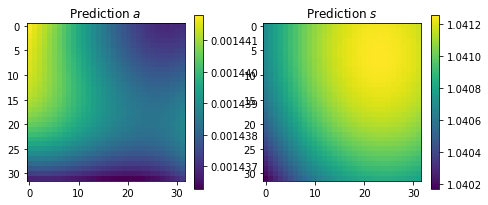

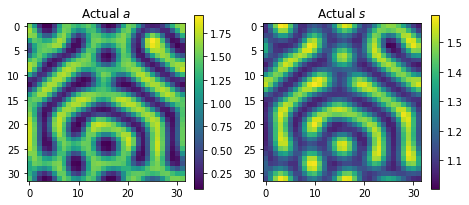

In [17]:
_ = plt.figure(figsize=(12,8))

plt.subplot(131)
plt.title(r"Prediction $a$")
plt.imshow(a_2)
plt.colorbar(shrink=.4)
plt.subplot(132)
plt.title(r"Prediction $s$")
plt.imshow(s_2)
plt.colorbar(shrink=.4)
plt.show()
_ = plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title(r"Actual $a$")
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.colorbar(shrink=.4)
plt.subplot(132)
plt.title(r"Actual $s$")
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.colorbar(shrink=.4)
plt.show()

In [18]:
graph = tf.get_default_graph()
tmp = graph.get_tensor_by_name("temp_a_t:0")
a_t = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_s_t:0")
s_t = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_a_diff:0")
a_diff = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_s_diff:0")
s_diff = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_kin:0")
kin = model.sess.run(tmp, tf_dict)

In [19]:
D_s = model.sess.run(model.D_s_tilde)[0]
sigma_s = model.sess.run(model.sigma_s)#[0]
rho_s = model.sess.run(model.rho_s_tilde)[0]

D_a_tilde = model.sess.run(model.D_a_tilde)[0]
sigma_a_tilde = model.sess.run(model.sigma_a_tilde)[0]
rho_a_tilde = model.sess.run(model.rho_a_tilde)[0]
mu_a_tilde = model.sess.run(model.mu_a_tilde)[0]
kappa_a = model.sess.run(model.kappa_a)
print(f"D_a_tilde = {D_a_tilde:.6f}, rho_a_tilde = {rho_a_tilde:.6f}, mu_a_tilde = {mu_a_tilde:.9f}, sigma_a_tilde = {sigma_a_tilde:.9f}, kappa_a = {kappa_a:.4f}")

# a_t - D_a_tilde*(a_xx + a_yy) - rho_a_tilde*f + mu_a_tilde*a - sigma_a_tilde
plt.figure(figsize=(18,12))
plt.subplot(3, 3, 1)
plt.title(r"$a_t$")
plt.imshow(a_t.reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 2)
plt.title(r"$-\nabla^2 a$")
plt.imshow((-a_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 3)
plt.title(r"$-\tilde{D}_a \nabla^2 a$")
plt.imshow((-D_a_tilde*a_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 4)
plt.title(r"$ \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 5)
plt.title(r"$ - \tilde{\rho}_a \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-rho_a_tilde*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 6)
plt.title(r"$-\tilde{D}_a \nabla^2 a - \tilde{\rho}_a \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-D_a_tilde*a_diff-rho_a_tilde*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 7)
plt.title(r"$-\tilde{D}_a \nabla^2 a - \tilde{\rho}_a \frac{a^2 s}{1 + \kappa_a a} + \tilde{\mu}_a a$")
plt.imshow((-D_a_tilde*a_diff-rho_a_tilde*kin+mu_a_tilde*a_2.flatten()[:, np.newaxis]).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 8)
plt.title(r"$-\tilde{D}_a \nabla^2 a - \tilde{\rho}_a \frac{a^2 s}{1 + \kappa_a a} + \tilde{\mu}_a a - \tilde{\sigma}_a$")
plt.imshow((-D_a_tilde*a_diff-rho_a_tilde*kin+mu_a_tilde*a_2.flatten()[:, np.newaxis]-sigma_a_tilde).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 9)
plt.title(r"$a_t-\tilde{D}_a \nabla^2 a - \tilde{\rho}_a \frac{a^2 s}{1 + \kappa_a a} + \tilde{\mu}_a a - \tilde{\sigma}_a$")
plt.imshow((a_t-D_a_tilde*a_diff-rho_a_tilde*kin+mu_a_tilde*a_2.flatten()[:, np.newaxis]-sigma_a_tilde).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.show()


AttributeError: 'PhysicsInformedNN' object has no attribute 'D_s'

D_s = 0.200000, rho_s = 0.020000, sigma_s = 0.020000, kappa_a = 0.2500


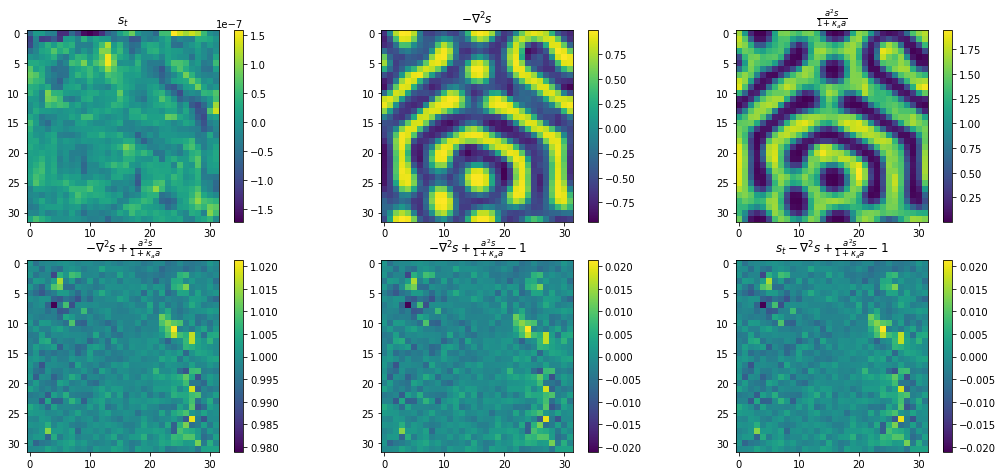

In [14]:
D_s = model.sess.run(model.D_s)#[0]
sigma_s = model.sess.run(model.sigma_s)#[0]
rho_s = model.sess.run(model.rho_s)#[0]

D_a_tilde = model.sess.run(model.D_a_tilde)[0]
sigma_a_tilde = model.sess.run(model.sigma_a_tilde)[0]
rho_a_tilde = model.sess.run(model.rho_a_tilde)[0]
mu_a_tilde = model.sess.run(model.mu_a_tilde)[0]
kappa_a = model.sess.run(model.kappa_a)

print(f"D_s = {D_s:.6f}, rho_s = {rho_s:.6f}, sigma_s = {sigma_s:.6f}, kappa_a = {kappa_a:.4f}")

# s_t - (s_xx + s_yy) + f - 1
plt.figure(figsize=(18,12))
plt.subplot(3, 3, 1)
plt.title(r"$s_t$")
plt.imshow(s_t.reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 2)
plt.title(r"$-\nabla^2 s$")
plt.imshow((-s_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 3)
plt.title(r"$\frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 4)
plt.title(r"$-\nabla^2 s + \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-s_diff+kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 5)
plt.title(r"$-\nabla^2 s + \frac{a^2 s}{1 + \kappa_a a} - 1$")
plt.imshow((-s_diff+kin-1).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 6)
plt.title(r"$s_t-\nabla^2 s +  \frac{a^2 s}{1 + \kappa_a a} - 1$")
plt.imshow((s_t-s_diff+kin-1).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.show()